# Gitcoin Subcommunities

(todo)

## Load data from pickle file
The model results have been pre-computed as a pickle file to save time for the user. For analyzing the network, there is no need to rerun the cadCAD model to conver the raw .csv or excel data to the pickled file. If the user would like to do so, they could by running the following:

```
python run_simulation.py
```

**Note:** The simulation is rather large, and may take several minutes to run, depending on your computer's RAM and CPU.

In [46]:
%load_ext autotime
import matplotlib.pyplot as plt
from collections import defaultdict
from model.parts.utils import *
import networkx as nx
import netwulf as nw
from networkx import community
import plotly.express as px
import numpy as np
import pandas as pd
import cloudpickle
import inequality_coefficients as ineq
from env_config import PICKLE_PATH
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import plotly.io as pio


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.6 ms (started: 2020-12-22 16:59:37 -03:00)


In [69]:
SEED = 5
pio.renderers.default = "jupyterlab"

time: 4.59 ms (started: 2020-12-22 17:09:02 -03:00)


In [3]:
with open(PICKLE_PATH, 'rb') as fid:
    result = cloudpickle.load(fid)

time: 46.8 s (started: 2020-12-22 16:42:30 -03:00)


## Network Analysis

### Outer product across contributor-pairs for the top 5 grants in terms of contribution amount

In [4]:
# Get the last graph
last_state = result.iloc[-1]

# Sum all the contributions for each contributor-grant pair
contributions_totals = (pd.DataFrame(last_state.contributions)
                          .groupby(['contributor', 'grant'])
                          .amount
                          .sum()
                          .pipe(pd.DataFrame)
                          )

time: 51 ms (started: 2020-12-22 16:17:38 -03:00)


#### Cluster map for the collaboration-grant outer product

/home/danlessa/.miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



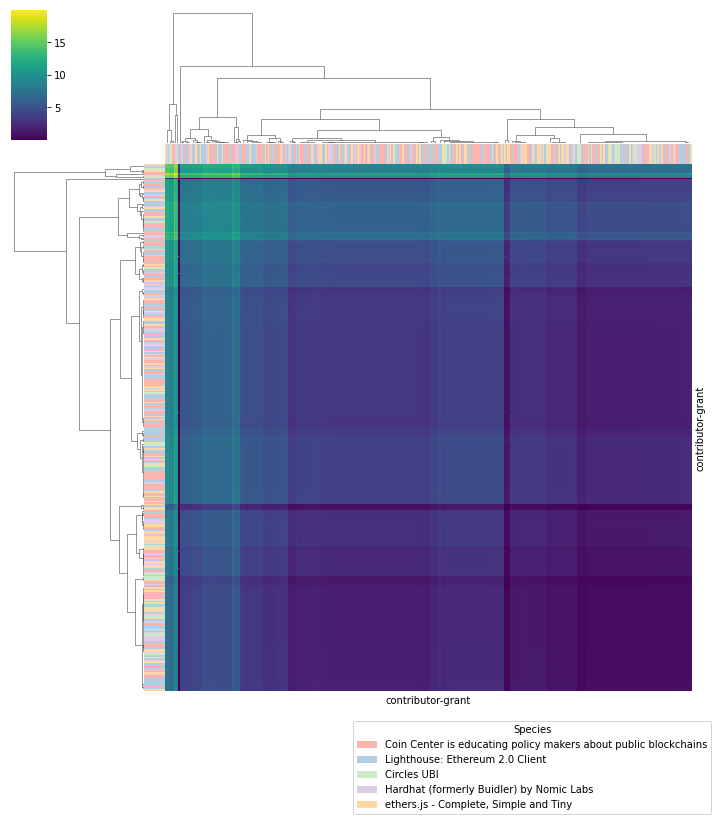

time: 4.07 s (started: 2020-12-22 16:17:39 -03:00)


In [5]:
# Filter out the top 5 grants with most contributions
top_grants = contributions_totals.groupby('grant').sum().sort_values('amount').tail(5)
x = contributions_totals.loc[(slice(None), top_grants.index), :]

# Get the outer product on the contributions totals vector
# Thanks @cs95
# https://stackoverflow.com/questions/47912611/compute-matrix-of-outer-operations-on-pandas-series
y = np.array(x.amount.tolist())
outer_df = pd.DataFrame(np.outer(y, y.T), index=x.index, columns=x.index)
outer_df = np.log(outer_df + 1)

# Plot a clustermap
grants_index = outer_df.index.get_level_values(1)
rgb_values = sns.color_palette("Pastel1", len(grants_index.unique()))
lut = dict(zip(grants_index.unique(), rgb_values))
row_colors = grants_index.map(lut)

sns.clustermap(outer_df,
               cmap='viridis',
               row_colors=row_colors,
               col_colors=row_colors,
               xticklabels=False,
               yticklabels=False)

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1, 0), bbox_transform=plt.gcf().transFigure)
plt.show()

#### Cluster map for the aggregated grants

/home/danlessa/.miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:3889: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



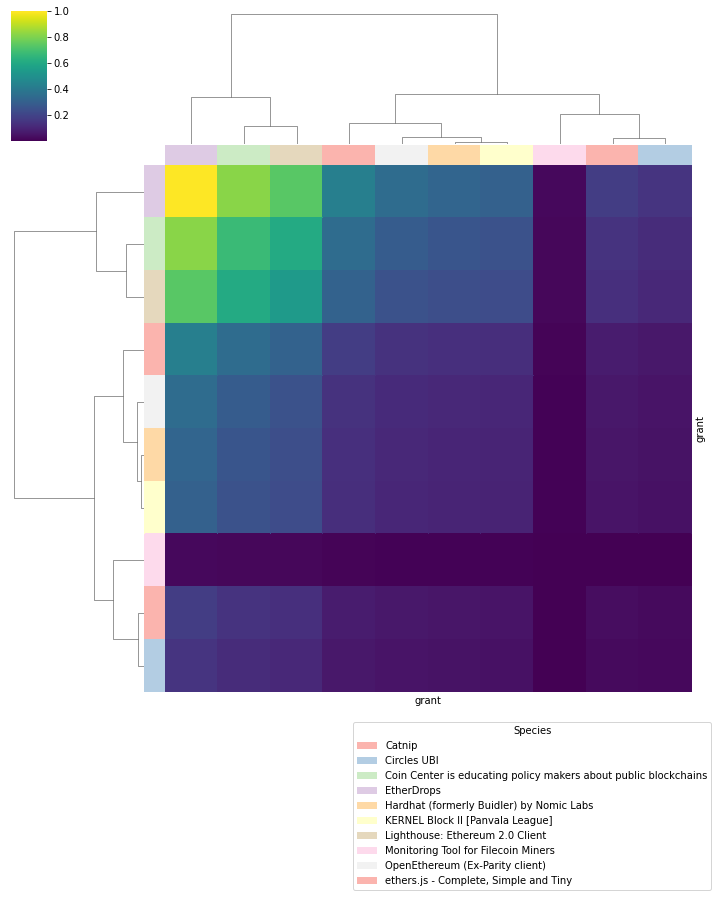

time: 2.63 s (started: 2020-12-22 16:17:43 -03:00)


In [6]:
# Filter out the top 10 grants with most contributions
top_grants = contributions_totals.groupby('grant').sum().sort_values('amount').tail(10)
x = contributions_totals.loc[(slice(None), top_grants.index), :]

# Get the outer product on the contributions totals vector
# Thanks @cs95 - https://stackoverflow.com/questions/47912611/compute-matrix-of-outer-operations-on-pandas-series
y = np.array(x.amount.tolist())
outer_df = np.log(pd.DataFrame(np.outer(y, y.T), index=x.index, columns=x.index) + 1)

outer_df = (outer_df.reset_index()
                    .groupby('grant')
                    .sum()
                    .T
                    .groupby('grant')
                    .sum()
                    .pipe(lambda df: df / df.max().max())
           )

# Plot a clustermap
grants_index = outer_df.index
rgb_values = sns.color_palette("Pastel1", len(grants_index.unique()))
lut = dict(zip(grants_index.unique(), rgb_values))
row_colors = grants_index.map(lut)

g = sns.clustermap(outer_df,
                   cmap='viridis',
                   row_colors=row_colors,
                   col_colors=row_colors,
                   xticklabels=False,
                   yticklabels=False)
                   
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45) # For x axis

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1, 0), bbox_transform=plt.gcf().transFigure)
plt.show()


### Gitcoin Communities

(write something here)

#### Growth of detected communities over time

In [4]:
def total_amount(G: nx.Graph,
                 node: str) -> float:
    """
    
    """
    node_edges = G.edges([node])
    total_amount = sum(G.edges[edge]['amount']
                       for edge
                       in node_edges)
    return total_amount

def contributions_to_graph(contrib_row: list) -> nx.Graph:
    """
    
    """
    if len(contrib_row) > 0:
        c_df = pd.DataFrame(contrib_row)
        

        
        G = nx.from_pandas_edgelist(c_df,
                                    source='contributor',
                                    target='grant',
                                    edge_attr=True)
        unique_grants = c_df.grant.unique()
        unique_contributors = c_df.contributor.unique()
        grant_node_type = {el: {'type': 'grant',
                                'total_amount': total_amount(G, el)} 
                           for el in unique_grants}
        contrib_node_type = {el: {'type': 'contributor',
                                  'total_amount': total_amount(G, el)} 
                             for el in unique_contributors}
        node_type = {**grant_node_type, **contrib_node_type}    
        
        nx.set_node_attributes(G, node_type)
        
        
        return G
    else:
        return None

graphs = result.contributions[1:100].map(contributions_to_graph)

time: 881 ms (started: 2020-12-22 16:43:16 -03:00)


In [5]:
community_count = lambda x: len(community.greedy_modularity_communities(x))

output = {}
for i, G in enumerate(tqdm(graphs)):
    output[i + 1] = community_count(G) 


time: 4.42 s (started: 2020-12-22 16:43:17 -03:00)


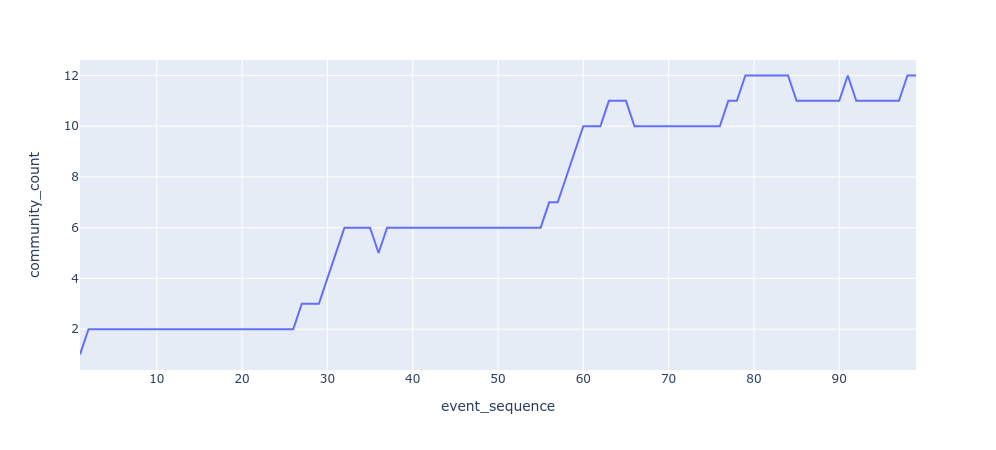

time: 1.82 s (started: 2020-12-22 16:43:22 -03:00)


In [6]:
s = pd.Series(output)
s.name = 'community_count'
s.index.name = 'event_sequence'

fig_df = s.reset_index()
px.line(fig_df,
        x='event_sequence',
        y='community_count')

#### Specific Communities

##### Preparation

In [92]:
G = contributions_to_graph(result.iloc[-1].contributions)
for node, data in G.nodes(data=True):
    data['group'] = data['type']
    data['size'] = np.sqrt(data['total_amount'])

G.nodes['cadCAD: Computer Aided Design for Complex Systems']

{'type': 'grant',
 'total_amount': 80.63361904193067,
 'group': 'grant',
 'size': 8.979622433149997}

time: 286 ms (started: 2020-12-22 17:24:03 -03:00)


In [93]:
giant_component = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(giant_component[0])

communities = list(community.asyn_fluidc(G0, 5, seed=SEED))

time: 1.11 s (started: 2020-12-22 17:24:03 -03:00)


In [94]:
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
from colormap import rgb2hex
N = len(communities)
color_labels = range(N)
rgb_values = sns.color_palette("Set2", N)
color_map = dict(zip(color_labels, rgb_values))
color_map = {key: rgb2hex(*[int(255 * i) for i in tup])
             for (key, tup) in color_map.items()}

attr_map = {}
for i, comm in enumerate(communities):
    community_map = {node: {'group': color_map[i]}
                     for node in comm}
    attr_map = {**attr_map, **community_map}
nx.set_node_attributes(G, attr_map)

NETWORK_VIZ_CONFIG= {'node_fill_color': '#79aaa0',
                     'node_size': 25,
                     'zoom': 0.7,
                     'gravity': 0.12,
                     'charge': -39,
                     'link_width': 1.1
                    }
nw.visualize(G, config=NETWORK_VIZ_CONFIG)

(None, None)

time: 28.9 s (started: 2020-12-22 17:24:04 -03:00)


In [ ]:
N = 2
color_labels = range(N)
rgb_values = sns.color_palette("Set2", N)
color_map = dict(zip(color_labels, rgb_values))
color_map = {key: rgb2hex(*[int(255 * i) for i in tup])
             for (key, tup) in color_map.items()}

node_attr = {}
for i, typ in enumerate(['grant', 'contributor']):
    type_attr = {node: {'group': color_map[i]}
                 for (node, d) in G.nodes(data=True)
                 if d['type'] == typ}
    node_attr = {**node_attr, **type_attr}
nx.set_node_attributes(G, node_attr)

nw.visualize(G, config=NETWORK_VIZ_CONFIG)

In [87]:
def plot_community(G0: nx.Graph,
                   communities: list,
                   community_label: str):
    generator = (g
                 for g in communities
                 if community_label in g)

    community_nodes = next(generator, None)

    if community_nodes is None:
        print(f"Community f{community_label} was not detected in the giant component")
        return None
    else:
        subgraph = G0.subgraph(community_nodes)
        
        N_grants = sum(1 
                       for label, node 
                       in subgraph.nodes(data=True) 
                       if node['type'] == 'grant')
        
        N_contributors = sum(1 
                             for label, node 
                             in subgraph.nodes(data=True) 
                             if node['type'] == 'contributor')
        
        subgraph_amount = sum(subgraph.edges[edge]['amount'] 
                              for edge 
                              in subgraph.edges())
        
        grant_amounts = {label: node['total_amount']
                         for (label, node) in subgraph.nodes(data=True)
                         if node['type'] == 'grant'}
        
        top_5_grants = sorted(grant_amounts.items(),
                              key=lambda it: it[1])[-5:]
        
        print(f"Total grants: {N_grants}")
        print(f"Total collaborators: {N_contributors}")
        print(f"Total USD value inside the subgraph: {subgraph_amount:,.2f} USD")
        print("Top 5 grants")
        print("---")
        for (grant, amount) in top_5_grants[::-1]:
            print(f"{grant}: {amount:,.2f} USD")
        
        return nw.visualize(subgraph, config=NETWORK_VIZ_CONFIG)

time: 4.53 ms (started: 2020-12-22 17:15:23 -03:00)


##### cadCAD: Computer Aided Design for Complex System

In [89]:
plot_community(G0, 
               communities, 
               'cadCAD: Computer Aided Design for Complex Systems')

Total grants: 136
Total collaborators: 246
Total USD value inside the subgraph: 36,767.52 USD
Top 5 grants}
---
Hardhat (formerly Buidler) by Nomic Labs: 8,410.78 USD
Circles UBI: 6,762.94 USD
ethers.js - Complete, Simple and Tiny: 3,445.22 USD
Catnip: 3,035.16 USD
OpenEthereum (Ex-Parity client): 2,493.97 USD


(None, None)

time: 54.6 s (started: 2020-12-22 17:16:18 -03:00)


##### MetaGame

In [90]:
plot_community(G0, 
               communities, 
               'MetaGame')

Total grants: 98
Total collaborators: 202
Total USD value inside the subgraph: 6,357.00 USD
Top 5 grants}
---
Grassroots Economics CIC Support - Kenya & Beyond: 1,187.72 USD
The Commons Stack: Iteration 0: 1,140.19 USD
Integrate Flexa Spend SDK in Nighthawk Wallet: 1,042.37 USD
APY.Vision: 855.21 USD
web3swift - Elegant Web3 functionality in Swift: 722.28 USD


(None, None)

time: 3min 10s (started: 2020-12-22 17:18:23 -03:00)


##### DAppChaser

In [91]:
plot_community(G0, 
               communities, 
               'DAppChaser')

Total grants: 40
Total collaborators: 232
Total USD value inside the subgraph: 8,622.14 USD
Top 5 grants}
---
EtherDrops: 3,361.53 USD
KERNEL Block II [Panvala League]: 2,873.05 USD
Zcash Serverless Store (Unofficial): 1,000.00 USD
DAppChaser: 877.84 USD
Solexplorer - Gitcoin Community Manager: 580.00 USD


(None, None)

time: 2min 27s (started: 2020-12-22 17:21:35 -03:00)
